In [1]:
import cv2
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
import pickle
import random
from statistics import harmonic_mean
import keras
from keras import backend as K

Using TensorFlow backend.


In [2]:
# Preprocessing
# This function creates image dataset after preprocessing images. Image can be grayscale or rgb
def create_image_data(CATEGORIES, img_size, dimension, DataDir):
    database = []
    for category in CATEGORIES:
        print(category)
        path = os.path.join(DataDir, category)
        class_num = CATEGORIES.index(category)
        for img_name in tqdm(os.listdir(path)):
            try:
                if dimension == 1:
                    img = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
                elif dimension == 3:
                    img = cv2.imread(os.path.join(path, img_name))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                else:
                    print('Please select dimension either 1 or 3')
                img = cv2.resize(img, (img_size, img_size))
                database.append([img, class_num])
            except Exception as e:
                pass
    return database

In [3]:
# Preprocessing
# This function preprocess single image
def prepare(filepath, IMG_SIZE, dimension):
    if dimension == 1:
        img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    elif dimension == 3:
        img_array = cv2.imread(filepath)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    else:
        print("Please select dimension either 1 or 3")
    new_array = new_array.reshape(-1, IMG_SIZE, IMG_SIZE, dimension)
    return new_array

In [4]:
IMG_SIZE = 200
DIM = 3
CATEGORIES = ["superficial", "deep", "full"]

TRAINDIR = "C:\Burns_BIP_US_database3\Training set"
TESTDIR = "C:\Burns_BIP_US_database3\Test"

In [5]:
# Create training dataset
training_data = create_image_data(CATEGORIES, IMG_SIZE, DIM, TRAINDIR)

# Randomize the dataset
random.shuffle(training_data)

XF = [] # XF will contain training image data
yF = []# yF will contain corresponding image class

for features,label in training_data:
    XF.append(features)
    yF.append(label)

XF = np.array(XF).reshape(-1, IMG_SIZE, IMG_SIZE, DIM)
print("Shape XF", XF.shape)
print(yF)

# Uncomment if want to save XF and yF for later use
'''
# Save it
pickle_out = open("XF.pickle","wb")
pickle.dump(XF, pickle_out)
pickle_out.close()

pickle_out = open("yF.pickle","wb")
pickle.dump(yF, pickle_out)
pickle_out.close()
'''

superficial


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 316.40it/s]


deep


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.36it/s]


full


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 313.88it/s]


Shape XF (46, 200, 200, 3)
[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 1, 1, 2, 0, 1, 0, 1, 0, 2, 0, 2, 2, 0, 0, 2, 1, 1, 2, 2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 1, 1, 1, 1]


'\n# Save it\npickle_out = open("XF.pickle","wb")\npickle.dump(XF, pickle_out)\npickle_out.close()\n\npickle_out = open("yF.pickle","wb")\npickle.dump(yF, pickle_out)\npickle_out.close()\n'

In [6]:
# Uncomment if want to load XF and yF again (only applicable if XF and yF are stored in previous cell)
'''
pickle_in = open("XF.pickle","rb")
XF = pickle.load(pickle_in)

pickle_in = open("yF.pickle","rb")
yF = pickle.load(pickle_in)
'''

'\npickle_in = open("XF.pickle","rb")\nXF = pickle.load(pickle_in)\n\npickle_in = open("yF.pickle","rb")\nyF = pickle.load(pickle_in)\n'

In [7]:
# Make model
XF2 = XF/255.0

model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', input_shape=XF2.shape[1:]))
model.add(Dropout(0.2))
model.add(BatchNormalization(axis = 1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),  padding = 'same')) #kernel_regularizer=regularizers.l2(0.05)
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Flatten())  

model.add(Dense(64))
model.add(Dropout(0.2))
#model.add(Dense(32))

model.add(Dense(len(CATEGORIES)))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
# Train model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto',
        restore_best_weights=True)

# using early stop
hist = model.fit(XF2, yF, batch_size=12, epochs=500, validation_split=0.15, callbacks=[monitor])

# without early stop
#hist = model.fit(XF, yF, batch_size=8, epochs=50, validation_split=0.2)

Train on 39 samples, validate on 7 samples
Epoch 1/500
39/39 [==============================] - ETA: 4s - loss: 0.8000 - acc: 0.666 - ETA: 1s - loss: 89.4059 - acc: 0.41 - ETA: 0s - loss: 136.0356 - acc: 0.388 - 3s 66ms/sample - loss: 135.5062 - acc: 0.3590 - val_loss: 7.6672 - val_acc: 0.2857
Epoch 2/500
39/39 [==============================] - ETA: 0s - loss: 20.1233 - acc: 0.41 - ETA: 0s - loss: 30.5087 - acc: 0.45 - ETA: 0s - loss: 35.5903 - acc: 0.41 - 0s 6ms/sample - loss: 37.2967 - acc: 0.4103 - val_loss: 4.8951 - val_acc: 0.2857
Epoch 3/500
39/39 [==============================] - ETA: 0s - loss: 11.4668 - acc: 0.66 - ETA: 0s - loss: 11.2023 - acc: 0.45 - ETA: 0s - loss: 8.2505 - acc: 0.4722 - 0s 6ms/sample - loss: 7.7540 - acc: 0.4615 - val_loss: 1.0671 - val_acc: 0.7143
Epoch 4/500
39/39 [==============================] - ETA: 0s - loss: 1.0372 - acc: 0.333 - ETA: 0s - loss: 0.9179 - acc: 0.500 - ETA: 0s - loss: 0.9267 - acc: 0.527 - 0s 6ms/sample - loss: 0.9386 - acc: 0.5128

In [9]:
#model.save('burn.model')

In [10]:
#model = tf.keras.models.load_model("burn.model")

In [11]:
model.summary() # Summary of the model in tabular form

model.get_config() # Get configuration of the entire model
model.layers[0].get_config() # Get configuration of a specific layer

model.count_params() # No. of parameters in the entire model
model.layers[0].count_params() # No. of parameters in a specific layer

model.get_weights() # Get weights and bias of the entire model
model.layers[0].get_weights() # Get weights and bias of a specific layer

model.layers[0].get_weights()[0] # Only weights
model.layers[0].get_weights()[1] # Only bias


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
dropout (Dropout)            (None, 200, 200, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 32)      800       
_________________________________________________________________
activation (Activation)      (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100, 64)      0

array([-0.01241513, -0.00329291, -0.01055284, -0.01264669, -0.00305101,
       -0.00667857,  0.00195892, -0.01287902, -0.0008905 , -0.00268113,
        0.01294468, -0.00951188,  0.0017203 ,  0.00365841, -0.01088976,
        0.01019809, -0.01084084, -0.01020257, -0.01079264,  0.01514967,
        0.01048298,  0.01347107, -0.00894235,  0.01376905,  0.00288793,
        0.01000291,  0.00649884, -0.0118416 , -0.00356993,  0.01609502,
       -0.01109108,  0.0137503 ], dtype=float32)

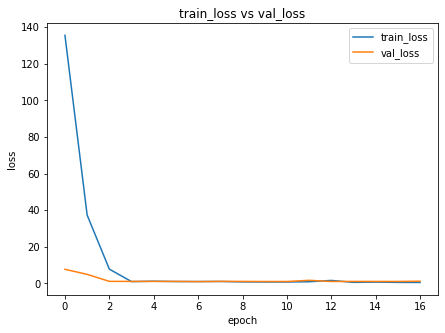

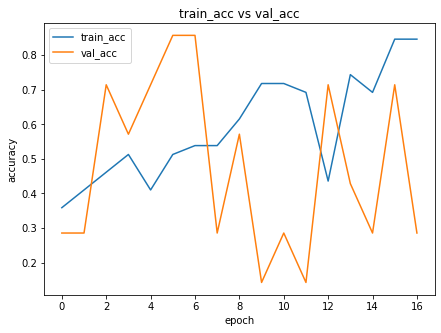

In [12]:
# Visualization
%matplotlib inline

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.figure(1, figsize = (7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.legend(['train_loss', 'val_loss'])

plt.figure(2, figsize = (7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.legend(['train_acc', 'val_acc'])

In [13]:
# Test
#model = tf.keras.models.load_model("burn.model")
filepath = r'C:\Burns_BIP_US_database\Burns_BIP_US_database\Testing set\24.jpg'
test_img = prepare(filepath, IMG_SIZE, DIM)
prediction = model.predict(test_img)
pred_img_class = np.argmax(prediction[0]) + 1 # one added because python starts from class 0


print("Class: ", pred_img_class, CATEGORIES[int(pred_img_class - 1)])


Class:  2 deep


In [14]:
# Create testing dataset
testing_data = create_image_data(CATEGORIES, IMG_SIZE, DIM, TESTDIR)

# Randomize the dataset
random.shuffle(testing_data)

Xt = []
yt = []

for features,label in testing_data:
    Xt.append(features)
    yt.append(label)

Xt = np.array(Xt).reshape(-1, IMG_SIZE, IMG_SIZE, DIM)
print("Shape Xt", Xt.shape)

print(yt)

# Uncomment if want to save Xt and yt
'''
# Save it
pickle_out = open("Xt.pickle","wb")
pickle.dump(Xt, pickle_out)
pickle_out.close()

pickle_out = open("yF.pickle","wb")
pickle.dump(yt, pickle_out)
pickle_out.close()

'''


superficial


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 745.03it/s]


deep


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 553.34it/s]


full


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 572.25it/s]


Shape Xt (48, 200, 200, 3)
[2, 1, 2, 2, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 2, 2, 0, 1, 1, 0, 1, 0, 0, 0, 0]


'\n# Save it\npickle_out = open("Xt.pickle","wb")\npickle.dump(Xt, pickle_out)\npickle_out.close()\n\npickle_out = open("yF.pickle","wb")\npickle.dump(yt, pickle_out)\npickle_out.close()\n\n'

In [15]:
# Evaluate
score = model.evaluate(Xt, yt, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy: ', score[1]*100)

Test Loss: 51.334312438964844
Test accuracy:  64.58333134651184


In [16]:
# Prediction
Xt = Xt/255.0
prediction = model.predict(Xt)

In [17]:
pred = np.argmax(prediction, axis = 1)

In [18]:
pred

array([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0], dtype=int64)

In [19]:
np.array(yt)

array([2, 1, 2, 2, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 2, 2, 0, 1, 1, 0, 1,
       0, 0, 0, 0])

In [20]:
# Create confusion matrix
conf_mat = confusion_matrix(yt, pred)
print(conf_mat)

[[15  7  0]
 [ 2 15  0]
 [ 5  4  0]]


In [21]:
# Pandas view of confusion matrix
df = pd.DataFrame(conf_mat, index = CATEGORIES, columns = CATEGORIES)
print(df)

             superficial  deep  full
superficial           15     7     0
deep                   2    15     0
full                   5     4     0


In [22]:
# Test accuracy
num = np.trace(conf_mat) # np.trace --> adds diagonal values
den = np.sum(np.sum(conf_mat, axis = 0))
test_acc = num/den

print("Correct instances: ", num)
print("All instances: ", den)
print("Test accuracy: ", test_acc*100)

Correct instances:  30
All instances:  48
Test accuracy:  62.5


In [23]:
# Create a function to calculate precision, recall and f1-score
def precision_recall_f1(conf_mat):
    # Precision
    vert_sum = np.sum(conf_mat, axis = 1) # Vertical sum
    diag_ele = np.diagonal(conf_mat) # Diagonal element
    cls_precision = diag_ele/vert_sum # Precision for each class
    precision = harmonic_mean(cls_precision) # take harmonic mean of individual classes

    # Recall
    horz_sum = np.sum(conf_mat, axis = 0) # Horizontal sum
    cls_recall = diag_ele/horz_sum
    recall = harmonic_mean(cls_recall)

    # F1-score
    f1_score = (2 * precision * recall)/(precision + recall)
    return precision, recall, f1_score


In [24]:
precision, recall, f1_score = precision_recall_f1(conf_mat)
print("Precision: %0.3f" %precision)
print("Recall: %0.3f" %recall)
print("F1_score: %0.3f" %f1_score)

C:\Anaconda3\lib\statistics.py:355: RuntimeWarning: divide by zero encountered in double_scalars
  T, total, count = _sum(1/x for x in _fail_neg(data, errmsg))
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Precision: 0.000
Recall: nan
F1_score: nan


In [25]:
filepath = r'C:\Burns_BIP_US_database3\Test\deep\23.jpg'
test_image = prepare(filepath, IMG_SIZE, DIM)

In [26]:
print((model.predict(test_image)))
print(model.predict_classes(test_image))

[[2.863466e-22 1.000000e+00 0.000000e+00]]
[1]




(1, 1, 200, 200, 32)
(200, 200, 32)


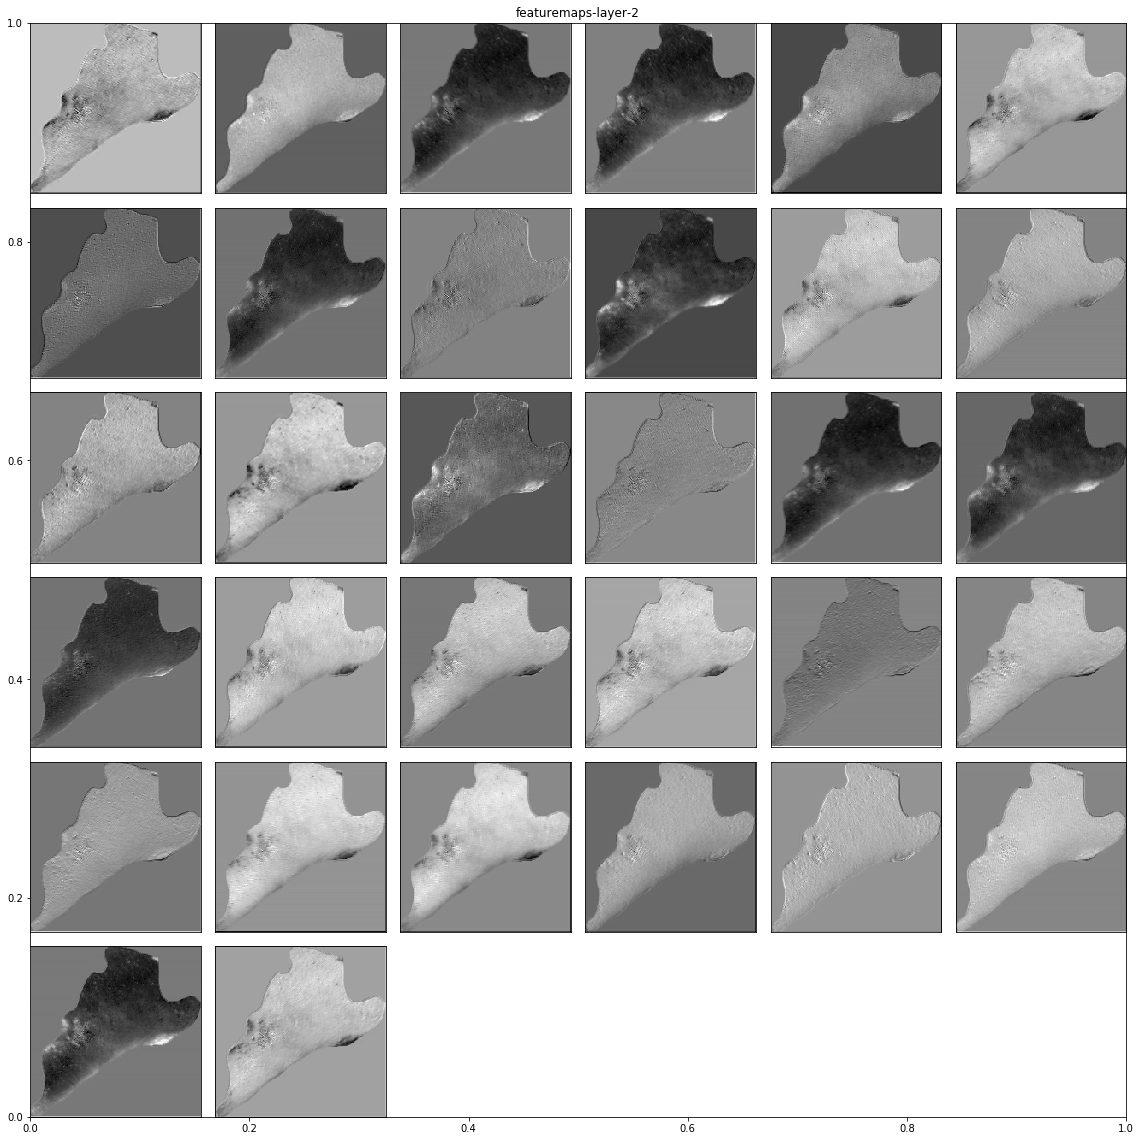

In [27]:
# Display feature map
def get_featuremaps(model, layer_idx, X_batch):
    get_activations = tf.keras.backend.function([model.layers[0].input, K.learning_phase()],[model.layers[layer_idx].output,])
    activations = get_activations([X_batch, 0])
    return activations

layer_num=2
filter_num=0

activations = get_featuremaps(model, int(layer_num), test_image)

print (np.shape(activations)) # (#img #channel #row #column #filter)
feature_maps = activations[0][0]      
print (np.shape(feature_maps))


'''
fig=plt.figure(figsize=(16,16))
plt.imshow(feature_maps[:,:,filter_num],cmap='gray')
plt.savefig("featuremaps-layer-{}".format(layer_num) + "-filternum-{}".format(filter_num)+'.jpg')
'''


num_of_featuremaps=feature_maps.shape[2]
fig=plt.figure(figsize=(16,16))
plt.title("featuremaps-layer-{}".format(layer_num))
subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
for i in range(int(num_of_featuremaps)):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    #ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
    ax.imshow(feature_maps[:,:,i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.savefig("featuremaps-layer-{}".format(layer_num) +'.jpg')
plt.show()


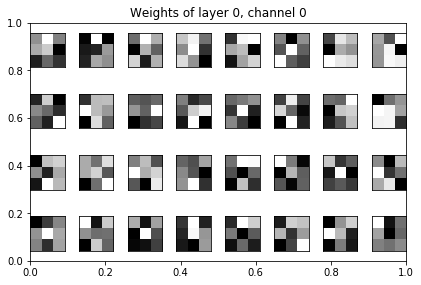

In [28]:
# Display weight matrix
layer_num = 0
channel_num = 0
filters = model.layers[layer_num].get_weights()[0]

fig = plt.figure()
plt.title('Weights of layer {}, channel {}'.format(layer_num, channel_num))
for i in range(0, 32):        
    ax = fig.add_subplot(4, 8, i+1)
    f1 = filters[channel_num, :, :, i]
    ax.matshow(f1, cmap = matplotlib.cm.binary)    
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.tight_layout()  
plt.savefig('weight matrix of layer {} and channel {}'.format(layer_num, channel_num) + '.jpg')